In [1]:
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import SkyOffsetFrame, ICRS, ITRS
import numpy as np

from h5parm import DataPack
from enu import ENU

2022-02-16 17:42:36,570 Note: NumExpr detected 64 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-02-16 17:42:36,571 NumExpr defaulting to 8 threads.


Josh's description of the screens

Phase conversion factor:
TEC_CONV = -8.4479745  # mTECU/MHz
phase = tec * TEC_CONV/freq_MHz

Params
Datetime: 2019-03-19T19:58:14.9-20:13:14.9
FOV: a 10.8deg diameter gives the 20% power point at the lowest frequency
Time resolution: I'm currently doing 1-min. The planned integration time is 1.5s. You can give me anything that makes sense to you,
00h00m0.0s +37.07.47.400s

# IO stuff

In [2]:
with DataPack('/fastpool/yuping/dsa2000W_datapack_1000m_single_timestep.h5', readonly=True) as dp:
    dp.current_solset = 'sol000'
    dp.select(pol=slice(0, 1, 1))
    tec_grid, axes = dp.tec #order=[pol,dir,ant,time]
    tec_grid = tec_grid[0]
    patch_names, directions_grid = dp.get_directions(axes['dir'])
    antenna_labels, antennas_grid = dp.get_antennas(axes['ant'])
    timestamps, times_grid = dp.get_times(axes['time'])

2022-02-16 17:42:38,616 Set current solset to: sol000
2022-02-16 17:42:38,617 Set current solset to: sol000


In [3]:
phase_center = SkyCoord(ra='00h00m0.0s', dec='+37d07m47.400s')
offsets = directions_grid.transform_to(SkyOffsetFrame(origin=phase_center))

In [4]:
def find_center(ants):
    ref_ant = ants[0]
    f = ENU(location=ref_ant.earth_location, obstime=times_grid[0])
    ants_enu = ITRS(*ants.cartesian.xyz, obstime=times_grid[0]).transform_to(f)
    mean_x = np.median(ants_enu.east.value)
    mean_y = np.median(ants_enu.north.value)
    print(mean_x, mean_y)
    ref_ind = np.argmin((ants_enu.east.value - mean_x)**2 + (ants_enu.north.value - mean_y)**2)
    print(ref_ind)
    return ref_ind
ref_ind = find_center(antennas_grid)

8756.913924420747 1228.0001867712188
180


In [5]:
from enu import ENU
frame = ENU(location=antennas_grid[ref_ind].earth_location, obstime=times_grid[0])
antennas_grid_enu = ITRS(*antennas_grid.cartesian.xyz, obstime=times_grid[0]).transform_to(frame)

In [6]:
antennas_grid_enu[182]

<ENU Coordinate (obstime=58561.83211689814, location=(-2410460.34700926, -4478594.69741199, 3839460.95482173) m): (east, north, up) in m
    (583.03925561, 1210.5101573, 0.4477418)>

For each antenna, plot all 277 directions
For each direction, plot all 390 antennas

In [7]:
(offsets.lat.max() - offsets.lat.min()).value

3.8546202340298565

In [8]:
(offsets.lon.max() - offsets.lon.min()).value

3.113419453355383

Now do a ICRS -> ENU conversion

Text(0.5, 1.0, 'Color=up')

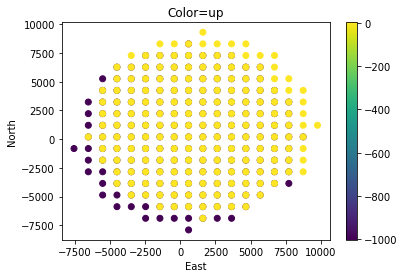

In [7]:
plt.scatter(antennas_grid_enu.east, antennas_grid_enu.north, c=antennas_grid_enu.up)
plt.colorbar()
plt.xlabel('East')
plt.ylabel('North')
plt.title('Color=up')

(array([  631.,  4815., 13223., 23160., 24781., 17769., 14074.,  7615.,
         1778.,   184.]),
 array([-47.16054227, -36.54404361, -25.92754496, -15.3110463 ,
         -4.69454764,   5.92195102,  16.53844968,  27.15494834,
         37.771447  ,  48.38794566,  59.00444432]),
 <BarContainer object of 10 artists>)

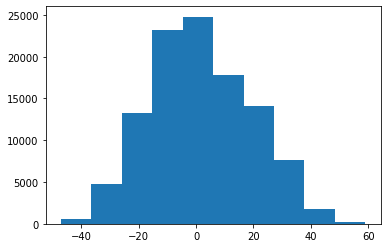

In [10]:
plt.hist(tec_grid.flatten())

In [105]:
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import Normalize

cs = Normalize(vmin=-40, vmax=40)
with PdfPages('per_direction.pdf') as pdf:
    for pp in range(tec_grid.shape[0] // 24 + 1):
        fig, axs = plt.subplots(6, 4, figsize=(6, 10.5))
        for i, ax in enumerate(axs.flatten()):
            patch = 24 * pp + i
            if patch > 276:
                break
            data = tec_grid[patch, :, 0]
            s = ax.scatter(antennas_grid.east/1e3, antennas_grid.north/1e3, s=2, c=data, norm=cs)
            ax.set_aspect(1)
            ax.set_title(f'{patch_names[patch]}, '
                         f'Delta={(np.max(data) - np.min(data)):.1f} '
                         f'std={(np.std(data)):.1f}', fontsize=3)
            ax.tick_params(axis='both', which='major', labelsize=3)
        cbar = fig.colorbar(s, ax=axs[-1,:], location='bottom', shrink=0.8)
        cbar.ax.tick_params(labelsize=5) 
        fig.suptitle('mTEC per direction over array')
        pdf.savefig()
        plt.close()

In [108]:
with PdfPages('per_ant.pdf') as pdf:
    for pp in range(tec_grid.shape[0] // 24 + 1):
        fig, axs = plt.subplots(6, 4, figsize=(6, 10.5))
        for i, ax in enumerate(axs.flatten()):
            ant = 24 * pp + i
            if ant > 389:
                break
            data = tec_grid[:, ant, 0]
            s = ax.scatter(offsets.lon, offsets.lat, s=2, c=data, norm=cs)
            ax.set_title(f'{antenna_labels[ant]}, '
                         f'Delta={(np.max(data) - np.min(data)):.1f} '
                         f'std={(np.std(data)):.1f}', fontsize=3)
            ax.tick_params(axis='both', which='major', labelsize=3)
        cbar = fig.colorbar(s, ax=axs[-1,:], location='bottom', shrink=0.8)
        cbar.ax.tick_params(labelsize=5) 
        fig.suptitle('mTEC per antenna over sky')
        pdf.savefig()
        plt.close()

Question: how much does the iono move (say with TIDS). 200km/h over 15 min is 50 km.

Need to figure out two things for single source sims:

- How to go from the screen to phase? i.e. should I be simulating a directional differential screen? What's the time structure of the phase? i.e. how do I simulate some post-calibration data?
- How does a single source simulation translate to how many fields will be problematic for us? I think we can just extend the MC simulation that Tyrone did and answer this question, or do it for all planned pointings. 


## Interpolate onto antennas

In [8]:
actual_ants = np.loadtxt('/home/yuping/frank/20210326-configs/20210226W.txt', usecols=(0,1))

In [9]:
from scipy.interpolate import griddata

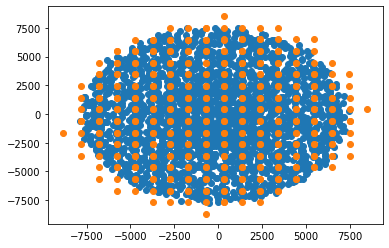

In [10]:
plt.scatter(actual_ants[:,0], actual_ants[:,1])
plt.scatter(antennas_grid_enu.east.value+(np.mean(actual_ants[:,0])-np.mean(antennas_grid_enu.east.value)),
            antennas_grid_enu.north.value+(np.mean(actual_ants[:,1]) - np.mean(antennas_grid_enu.north.value)))

In [11]:
tec_screens = griddata((antennas_grid_enu.east.value+(np.mean(actual_ants[:,0])-np.mean(antennas_grid_enu.east.value)),
                        antennas_grid_enu.north.value+(np.mean(actual_ants[:,1]) - np.mean(antennas_grid_enu.north.value))),
                       np.swapaxes(tec_grid, 0, 1),
                       actual_ants, method='linear')

In [10]:
np.any(np.isnan(tec_screens))

False

In [11]:
np.max(tec_screens), np.min(tec_screens)

(56.19602159153455, -46.68603332095727)

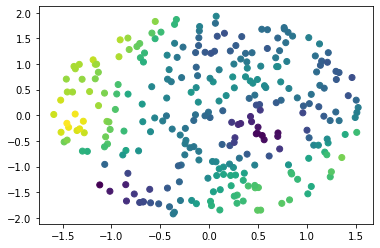

In [16]:
plt.scatter(offsets.lon, offsets.lat, c=tec_screens[0])

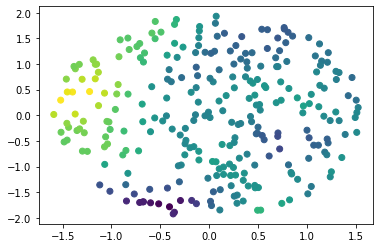

In [17]:
plt.scatter(offsets.lon, offsets.lat, c=tec_screens[1004])

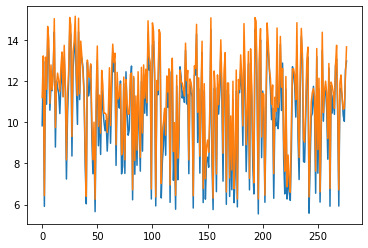

In [262]:
plt.plot(np.std(tec_screens, axis=0)[:,0])
plt.plot(np.std(tec_grid, axis=1)[:,0])

In [19]:
np.argmax(np.std(tec_screens, axis=0)[:,0])

30

In [18]:
tec_screens[:,30,0]

array([16.33529866, 18.85477131, 20.13002968, ...,  1.97871816,
        1.29894574,  2.36395504])

In [12]:
TEC_CONV = -8.4479745  # mTECU/MHz
freq_arr = (np.arange(8000) * 162.5e3) + 0.7e9
iono_gains = np.exp(1j * tec_screens[:,30, None, None] * (TEC_CONV * 1e6 /freq_arr)[None, :, None, None]) * np.identity(2)

In [13]:
iono_gains.shape

(2048, 8000, 2, 2)

(array([[ 107.,   82.,  242.,  466.,  329.,  217.,  256.,  198.,  117.,
           34.],
        [   0.,    0.,    0.,    0.,    0.,    0., 2048.,    0.,    0.,
            0.]]),
 array([-0.48913961, -0.40825438, -0.32736915, -0.24648393, -0.1655987 ,
        -0.08471348, -0.00382825,  0.07705697,  0.1579422 ,  0.23882742,
         0.31971265]),
 <a list of 2 BarContainer objects>)

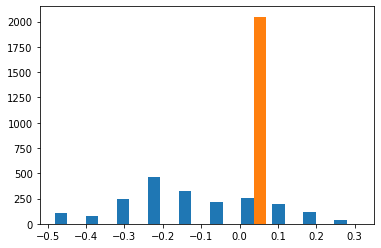

In [24]:
plt.hist(np.angle(iono_gains[:, 0, 0]))

(array([107.,  82., 242., 466., 329., 217., 256., 198., 117.,  34.]),
 array([-0.22637866, -0.18894418, -0.15150969, -0.11407521, -0.07664072,
        -0.03920624, -0.00177175,  0.03566273,  0.07309722,  0.1105317 ,
         0.14796618]),
 <BarContainer object of 10 artists>)

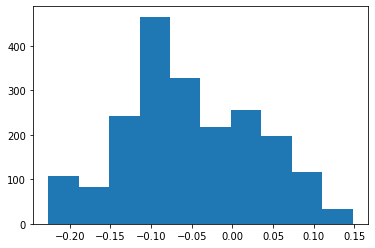

In [297]:
plt.hist(np.angle(iono_gains[:, 5000, 0]))

(array([107.,  82., 242., 466., 329., 217., 256., 198., 117.,  34.]),
 array([-0.17121277, -0.14290064, -0.11458851, -0.08627639, -0.05796426,
        -0.02965213, -0.00134   ,  0.02697213,  0.05528426,  0.08359639,
         0.11190852]),
 <BarContainer object of 10 artists>)

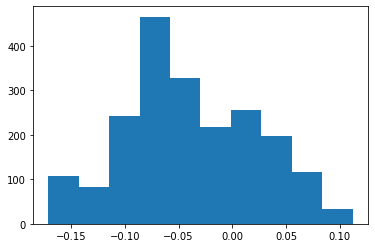

In [298]:
plt.hist(np.angle(iono_gains[:, 7999, 0]))

In [14]:
iono_gains = iono_gains[np.newaxis,:]

In [15]:
iono_gains.shape

(1, 2048, 8000, 2, 2)

In [19]:
iono_gains[0,0,0]

array([[0.98063015-0.19586859j, 0.        +0.j        ],
       [0.        +0.j        , 0.98063015-0.19586859j]])

In [16]:
import dftsource

In [29]:
from importlib import reload
reload(dftsource)

<module 'dftsource' from '/home/yuping/sim-toolkit/notebooks/dftsource.py'>

In [22]:
import dask.array as da
dftsource.point_src_with_gain(iono_gains, '/fastpool/data/W-snapshot-8000chan.ms')

[########################################] | 100% Completed | 21min 51.0s


In [395]:
5000*8000*4

160000000

# Did I get it right?

In [27]:
from casacore.tables import table
import numpy as np

In [2]:
with table('/fastpool/data/W-snapshot-8000chan.ms') as t:
    first_row = t.getcol('DATA',nrow=1)

Successful readonly open of default-locked table /fastpool/data/W-snapshot-8000chan.ms: 22 columns, 2096128 rows


In [3]:
first_row

array([[[0.99953777+0.03040166j, 0.        +0.j        ,
         0.        +0.j        , 0.99953777+0.03040166j],
        [0.999538  +0.0303946j , 0.        +0.j        ,
         0.        +0.j        , 0.999538  +0.0303946j ],
        [0.9995382 +0.03038755j, 0.        +0.j        ,
         0.        +0.j        , 0.9995382 +0.03038755j],
        ...,
        [0.9999433 +0.01064461j, 0.        +0.j        ,
         0.        +0.j        , 0.9999433 +0.01064461j],
        [0.9999434 +0.01064375j, 0.        +0.j        ,
         0.        +0.j        , 0.9999434 +0.01064375j],
        [0.9999434 +0.01064288j, 0.        +0.j        ,
         0.        +0.j        , 0.9999434 +0.01064288j]]],
      dtype=complex64)

In [7]:
np.angle(first_row[0,:,0])

array([0.03040634, 0.03039929, 0.03039223, ..., 0.01064481, 0.01064395,
       0.01064308], dtype=float32)

In [25]:
iono_gains[0, 0] * np.conj(iono_gains[1, 0]).T

array([[0.99953776+0.03040166j, 0.        +0.j        ],
       [0.        +0.j        , 0.99953776+0.03040166j]])

In [24]:
iono_gains[1, 0]

array([[0.97422214-0.22559084j, 0.        +0.j        ],
       [0.        +0.j        , 0.97422214-0.22559084j]])

In [31]:
with table('/fastpool/data/W-snapshot-8000chan.ms') as t:
    row = t.getcol('DATA',64000, 1)
    ant1 = t.getcol('ANTENNA1',64000, 1)
    ant2 = t.getcol('ANTENNA2',64000, 1)

Successful readonly open of default-locked table /fastpool/data/W-snapshot-8000chan.ms: 22 columns, 2096128 rows


In [32]:
ant1

array([31], dtype=int32)

In [33]:
ant2

array([1040], dtype=int32)

In [34]:
iono_gains[31, 0] * np.conj(iono_gains[1040, 0]).T

array([[0.9577781-0.28750845j, 0.       +0.j        ],
       [0.       +0.j        , 0.9577781-0.28750845j]])

In [35]:
row

array([[[0.9577781 -0.28750846j, 0.        +0.j        ,
         0.        +0.j        , 0.9577781 -0.28750846j],
        [0.9577976 -0.28744364j, 0.        +0.j        ,
         0.        +0.j        , 0.9577976 -0.28744364j],
        [0.957817  -0.28737882j, 0.        +0.j        ,
         0.        +0.j        , 0.957817  -0.28737882j],
        ...,
        [0.994793  -0.10191618j, 0.        +0.j        ,
         0.        +0.j        , 0.994793  -0.10191618j],
        [0.99479383-0.10190792j, 0.        +0.j        ,
         0.        +0.j        , 0.99479383-0.10190792j],
        [0.99479467-0.10189967j, 0.        +0.j        ,
         0.        +0.j        , 0.99479467-0.10189967j]]],
      dtype=complex64)

In [37]:
iono_gains[31, -1] * np.conj(iono_gains[1040, -1]).T

array([[0.99479468-0.10189967j, 0.        +0.j        ],
       [0.        +0.j        , 0.99479468-0.10189967j]])

In [17]:
dftsource.point_src_with_gain(iono_gains, '/fastpool/data/W-snapshot-8000chan.ms', rms=0.366268)

[########################################] | 100% Completed | 18min 20.3s
